In [3]:
# Import packages and modules
%cd ..
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import src.markowitz as mk
import src.option_pricing as option_pricing

/Users/joseartes/python/montecarlo-basics-fin-maths


# Monte Carlo: An Introduction to its Applications in Financial Mathematics

### 1. Introduction

*Monte Carlo is a method whereby a deterministic quantity (e.g., number pi) is estimated via random sampling.*

#### Example

Consider the integral $ \int_{2}^{5} x^2 e^{-x^3} \, dx $. This can clearly be solved as follows: $ \int_{2}^{5} x^2 e^{-x^3} \, dx = -\frac{1}{3} \int_{2}^{5} -3x^2 e^{-x^3} \, dx = \left[-\frac{1}{3} \cdot e^{-x^3}\right]_{2}^{5} $ = $ \left(-\frac{1}{3} \cdot e^{-5^3}\right) + \left(\frac{1}{3} \cdot e^{-2^3}\right) = -1.12 \cdot 10^{-4}$ However, things become trickier when asked to solve the integral $ \int_{2}^{5} e^{-x^3} \, dx $. This integral, in fact, lacks a closed-form solution, which means that we have to resort to numerical methods to solve it, such as Monte Carlo.

Before solving the integral, we will introduce the notion of the $ U\left(0,1\right)$ distribution i.e., the uniform distribution within the $\left(0,1\right)$ domain. This will lay the foundations of calculating the deterministic outcome of integrals via Monte Varlo by sampling a sequence of random numbers that follow this distribution.

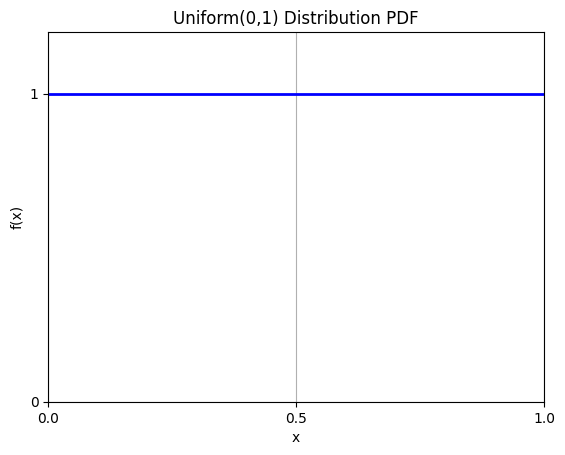

In [11]:
x = np.linspace(0, 1, 100)
y = np.ones_like(x)

plt.plot(x, y, color='blue', linewidth=2)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Uniform(0,1) Distribution PDF')
plt.ylim(0, 1.2)
plt.xlim(0, 1)
plt.xticks([0, 0.5, 1])
plt.yticks([0, 1])
plt.grid(True)
plt.show()


The probability density function of the $ U\left(0,1\right)$ distribution is expressed as
$$
p(x) = \begin{cases}
1, & \text{if } 0 \leq x \leq 1 \\
0, & \text{otherwise}
\end{cases}
$$

This means that that its expected value can simply be expressed as $ E[X] = \int_{0}^{1} xp(x) \, dx  = \int_{0}^{1} x \, dx $. If we can therefore express the above integral in this form, we can sample a sufficiently large sequence of random numbers from the $ U\left(0,1\right)$ and calculate their average to reach the solution approximation. This is because Monte Carlo depends on the Law of Large Numbers to be satisfied.

Firstly, we need to re-express $ \int_{2}^{5} e^{-x^3} \, dx $ such that the limits change from $2$ and $5$ to $0$ and $1$ respectively, and at the same time apply a suitable substitution for $x$. We can do this via $u=\frac{x-a}{b-a}$, which is very similar to the min-max feature scaling technique. Through the above equality we can see that $x=3u+2$ and hence that $\frac{du}{dx}=\frac{x}{b}\implies dx=3du$. Therefore, if we replace these identities in the integral we can see that $ \int_{2}^{5} e^{-x^3} \, dx = 3\int_{0}^{1} e^{-(3u+2)^3} \, du \approx 3\Sigma_{i=1}^n \frac{e^{-(3u_{i}+2)^3}}{n}$ when $n\rightarrow\infty$ - let's verify this below by sampling $25000$ random numbers from the $ U\left(0,1\right)$ distribution and compare against the actual result reached via the ```scipy.integrate``` module.

In [38]:
import scipy.integrate as integrate
import math
import random

# Define function
def mc_integral(n_sims):
    mc_fun = 0
    for i in range(n_sims):
        mc_fun += 3*math.e**(-(3*random.random() + 2)**3)
    return mc_fun / n_sims

# Solve via Scipy quad integration method
scipy_result = integrate.quad(lambda x: math.e**(-x**3), 2, 5)
print(f"Scipy Result: {scipy_result[0]}")
# Solve via Monte Carlo
print(f"Monte Carlo Result: {mc_integral(250000)}")

Scipy Result: 2.5997275372899832e-05
Monte Carlo Result: 2.6190757713788362e-05


We see that indeed both results converge and that Monte Carlo has proven to be successful for estimating the function. In fact, below it can be seen that as we increase the number of simulations, the average of the function outputs converges towards the actual solution!

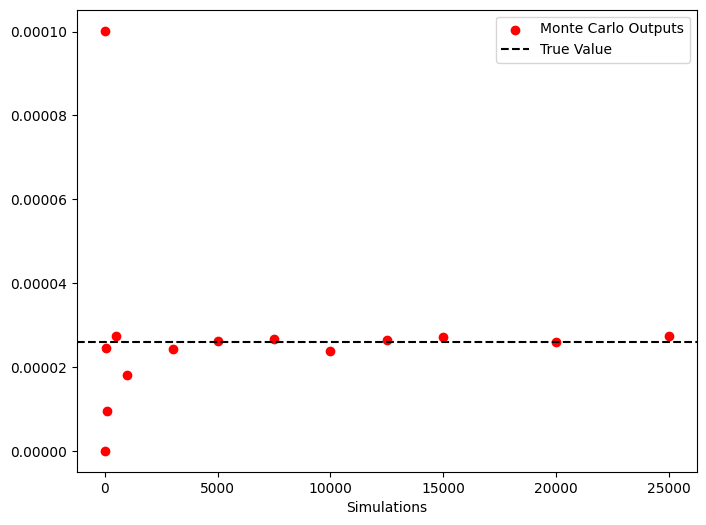

In [45]:
n_sims = [1,10,50,100,500,1000,3000,5000,7500,10000,12500,15000,20000,25000]
mc_results = [mc_integral(n) for n in n_sims]
plt.figure(figsize=(8,6))
plt.scatter(n_sims, mc_results, c="red", label="Monte Carlo Outputs")
plt.axhline(scipy_result[0], c="black", linestyle="--", label="True Value")
plt.legend()
plt.xlabel("Simulations")
plt.show()

### 2. Markowitz Portfolio Theory

Markowitz Portfolio Theory, sometimes also known as Modern Portfolio Theory (MPT), is a method that enables the selection of investments of a portfolio that maximises the returns with an acceptable level of risk. It assumes that all investors are risk-averse, meaning that if one has to choose between two investments with the same returns but different risk-levels, the one with the lowest risk would ultimately be selected.

Let us assume we hold a portfolio in which we allocate proportions of our capital – represented by $\vec{\pi}=\left(\pi_{1}, \pi_{2},...,\pi_{n}\right)$ such that $\vec{1}^{T}\cdot\vec{\pi}^{T}=\Sigma_{i=1}^n\mu_{i}=1$ – towards $n$ stocks with their respective average daily returns $\vec{\mu}=\left(\mu_{1}, \mu_{2},...,\mu_{n}\right)$. Additionally, let us define the portfolio return as $\mu_{P}=\vec{\pi}\cdot\vec{\mu}^{T}=\Sigma_{i=1}^n \pi_{i}\mu_{i}$ and portfolio standard deviation (i.e., risk) as $ \sigma_{P}=\vec{\pi}\cdot\vec{\Sigma}\cdot\vec{\pi}^{T} $ where 
$$ 
\vec{\Sigma}\ = \begin{pmatrix}
\sigma_{1}^{2} & \sigma_{12} & ... & \sigma_{1n}\\
\sigma_{21} & \sigma_{2}^{2} & ... & \sigma_{2n}\\
... & ... & ... & ... \\
\sigma_{n1} & \sigma_{n2} & ... & \sigma_{n}^{2}
\end{pmatrix}
$$

is the covariance matrix of the individual stocks that compose the portfolio.

When MPT is concerned, there are typically **two** main portfolios that are of interest:
1. **Maximum Sharpe Ratio Portfolio**: This portfolio is the one that maximises the returns while simultaneously minimising the risk - this is quantified as $S=\frac{\mu_{P}-R_{f}}{\sigma_{P}}$. **Note:** $R_{f}$ denotes the risk-free rate of return e.g., interest rate paid by US treasury bills or UK gilts. However, for this example we will not consider this as part of our portfolio, which means we can express the ratio as $S=\frac{\mu_{P}}{\sigma_{P}}$.
2. **Minimum Variance Portfolio**: This portfolio is solely concerned with minimising the variance (or standard deviation) $\sigma_{P}$, regardless of the portfolio return $\mu_{P}$.

One can quickly realise that finding the above two portfolios concerns a constrained optimisation problem. Namely, for **1.**:
$$
\max_{\vec{\pi}}\frac{\mu_{P}}{\sigma_{P}}=-\min_{\vec{\pi}}\frac{\mu_{P}}{\sigma_{P}}: \mu_{P}=\vec{\pi}\cdot\vec{\mu}^{T};\;\vec{1}^{T}\cdot\vec{\pi}^{T}=1
$$
and for **2.**:
$$
\min_{\vec{\pi}}\vec{\pi}\cdot\vec{\Sigma}\cdot\vec{\pi}^{T}: \mu_{P}=\vec{\pi}\cdot\vec{\mu}^{T};\; \vec{1}^{T}\cdot\vec{\pi}^{T}=1
$$

The above optimisation problems can be solved via different methods, but in this example we will be solving it via Monte Carlo and the SQLSQP (Sequential Least Squares Programming) numerical optimisation method from the ```scipy.minimize``` module. The former method will involve random sampling a sufficienty large enough array of numbers that follow the $Dirichlet\left(\vec{\alpha}=\vec{1}\right)$ distribution, which is a generalisation of the $Beta\left(\alpha,\beta\right)$ distribution, since this will allow us to randomly generate proportion vectors $\{\vec{\pi}_{1},\vec{\pi}_{2},...,\vec{\pi}_{n}\}$ for our constructed portfolio. For all sequence of randomly generated proportion vectors  we will calculate their Sharpe ratios $\{S^{1},S^{2},...,S^{n}\}$ and portfolio standard deviations $\{\sigma_{P}^{1},\sigma_{P}^{2},...,\sigma_{P}^{n}\}$ and ultimalely find their maximum and minimum respectively.

For this exercise I have pulled the daily price of **four** stocks from top market capitalisation S&P500 technology firms (Nvidia, Apple, Tesla and Microsoft) from 2022-06-02 to 2023-06-02 via the marketstack API.

In [3]:
df_raw = pd.read_csv("data/stocks_raw.csv")
df_returns = pd.read_csv("data/stocks_returns.csv", index_col="date")

In [5]:
df_raw.sort_values(["symbol", "date"], ascending=[True,True])

,open,high,low,close,volume,adj_high,adj_low,adj_close,adj_open,adj_volume,split_factor,dividend,symbol,exchange,date
996,147.03,148.5689,144.900,146.14,70931362.0,NaN,NaN,146.14,NaN,NaN,1.0,0.0,AAPL,XNAS,2022-06-06
992,144.35,149.0000,144.100,148.71,67713600.0,NaN,NaN,148.71,NaN,NaN,1.0,0.0,AAPL,XNAS,2022-06-07
988,148.58,149.8700,147.460,147.96,53895900.0,NaN,NaN,147.96,NaN,NaN,1.0,0.0,AAPL,XNAS,2022-06-08
984,147.08,147.9500,142.530,142.64,69367400.0,NaN,NaN,142.64,NaN,NaN,1.0,0.0,AAPL,XNAS,2022-06-09
980,140.28,140.7600,137.060,137.13,91437900.0,NaN,NaN,137.13,NaN,NaN,1.0,0.0,AAPL,XNAS,2022-06-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,184.62,198.6000,184.530,193.17,162061496.0,198.60,184.530,193.17,184.62,162061496.0,1.0,0.0,TSLA,XNAS,2023-05-26
15,200.10,204.4800,197.530,201.16,128818746.0,204.48,197.530,201.16,200.10,128818746.0,1.0,0.0,TSLA,XNAS,2023-05-30
11,199.78,203.9500,195.120,203.93,150711736.0,203.95,195.120,203.93,199.78,149356274.0,1.0,0.0,TSLA,XNAS,2023-05-31
7,202.59,209.8000,199.370,207.52,148029931.0,209.80,199.370,207.52,202.59,148029931.0,1.0,0.0,TSLA,XNAS,2023-06-01


The logarithmic daily returns are also calculated within the module where the data is pulled via the API.

In [32]:
df_returns

,AAPL,MSFT,NVDA,TSLA
date,,,,
2022-06-07,0.017433,0.013857,0.007425,0.002543
2022-06-08,-0.005056,-0.007699,-0.014798,0.012397
2022-06-09,-0.036618,-0.021002,-0.032704,-0.008971
2022-06-10,-0.039395,-0.045587,-0.061352,-0.031688
2022-06-13,-0.039037,-0.043338,-0.081404,-0.073670
...,...,...,...,...
2023-05-26,0.014006,0.021160,0.025116,0.046084
2023-05-30,0.010603,-0.005059,0.029475,0.040530
2023-05-31,-0.000282,-0.008551,-0.058442,0.013676


Since we are considering a technological portfolio, the correlation seems to be moderate to high, particularly between AAPL and MSFT.

<Axes: >

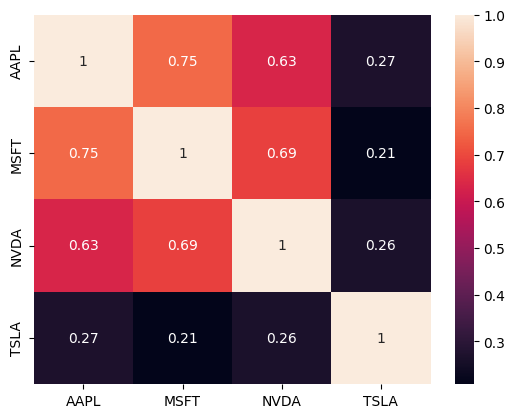

In [6]:
sns.heatmap(df_returns.corr(), annot=True)

The time-series for the log-returns exhibit notable extreme points such as the 3:1 stock split that Tesla executed on August 24th 2022, where the shares dropped from $892.29 closing price to $302 open price. Similarly, Nvidia's rise to the 4th position in the S&P500 by market capitalisation is also reflected towards the end of the time series.

<Axes: xlabel='date'>

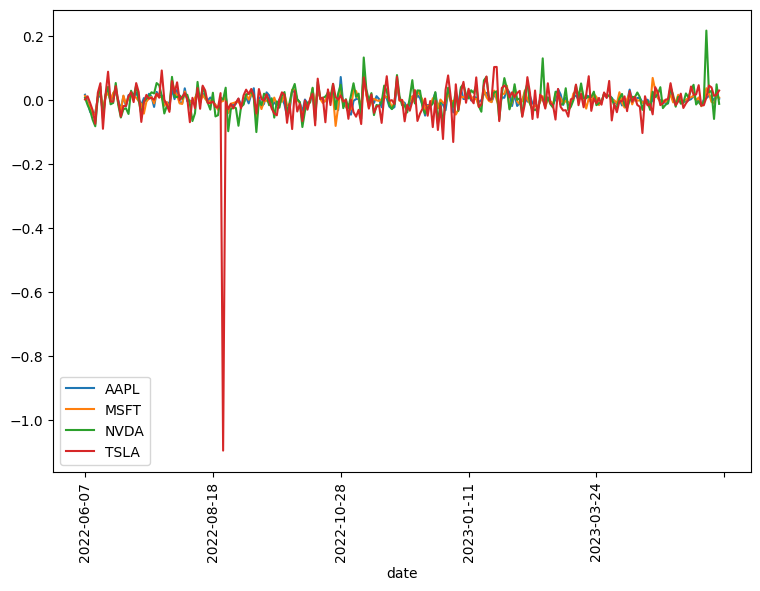

In [34]:
df_returns.plot(figsize=(9,6),rot=90)

I will instantiate an object from the ```Markowitz``` class and assign it the log-return dataframe as its parameter.

In [4]:
mk = mk.Markowitz(df_returns)

We will then choose to simulate 100,000 random portfolios, where for each we display $\mu_{P},\: \sigma_{P},\: S$.

In [27]:
df_sim = mk.simulate_portfolios(50000)
df_sim

,w0,w1,w2,w3,mu_p,sigma_p,sharpe
0,0.370687,0.119809,0.433183,0.076321,0.337739,0.410197,0.823358
1,0.019843,0.615530,0.153219,0.211407,-0.001215,0.430648,-0.002821
2,0.041286,0.613317,0.254624,0.090773,0.226011,0.380938,0.593300
3,0.028668,0.357284,0.108572,0.505475,-0.449576,0.703852,-0.638736
4,0.143334,0.209936,0.173909,0.472821,-0.369104,0.677400,-0.544883
...,...,...,...,...,...,...,...
49995,0.775038,0.039711,0.038799,0.146452,0.026718,0.363699,0.073461
49996,0.440332,0.215094,0.028972,0.315602,-0.220172,0.497204,-0.442820
49997,0.420463,0.115798,0.386709,0.077031,0.311987,0.396983,0.785895
49998,0.314433,0.059400,0.097654,0.528514,-0.490863,0.729409,-0.672960


We then calculate the maximum and minimum of the ```sharpe``` and ```sigma_p``` columns respectively.

In [28]:
df_sim[df_sim["sharpe"] == df_sim["sharpe"].max()]

,w0,w1,w2,w3,mu_p,sigma_p,sharpe
38459,0.013176,0.000683,0.984027,0.002114,0.736178,0.584607,1.259271


In [29]:
df_sim[df_sim["sigma_p"] == df_sim["sigma_p"].min()]

,w0,w1,w2,w3,mu_p,sigma_p,sharpe
38144,0.66365,0.331033,0.001605,0.003712,0.21439,0.299383,0.716107


We now call the ```optimal_portfolio()``` method to compute the Minimum Variance and Maximum Sharpe ratio portfolios through the SLSQP method and display their respective outputs.

In [15]:
df_max_sharpe = mk.optimal_portfolio("max-sharpe")

In [16]:
df_min_var = mk.optimal_portfolio("min-var")

In [17]:
df_max_sharpe

,w0,w1,w2,w3,mu_p,sigma_p,sharpe
0,2.688544e-13,1.840889e-14,1.0,0.0,0.747701,0.590573,1.26606


In [18]:
df_min_var

,w0,w1,w2,w3,mu_p,sigma_p,sharpe
0,0.627147,0.372853,1.040834e-16,0.0,0.219206,0.298905,0.733364


With all these outputs we are able to generate a scatter plot with a colour map that changes based on the Sharpe ratio of the portfolios, and we can clearly see that the Monte Carlo and numerical optimisation solutions are incredibly close, again, proving that Monte Carlo can help us approximate an uncertain deterministic quantity through random sampling.

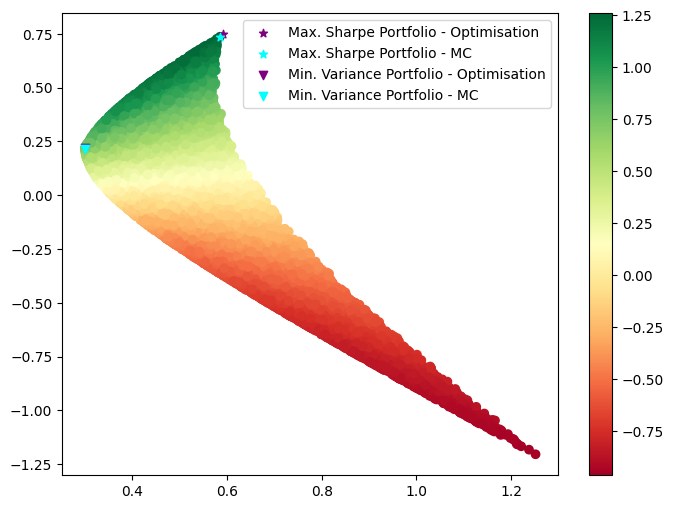

In [30]:
plt.figure(figsize=(8,6))
fig = plt.scatter(x=df_sim["sigma_p"],
            y=df_sim["mu_p"],
            c=df_sim["sharpe"],
            cmap="RdYlGn")
plt.scatter(x=df_max_sharpe["sigma_p"],
            y=df_max_sharpe["mu_p"],
            marker="*",
            c="purple",
            label="Max. Sharpe Portfolio - Optimisation")
plt.scatter(x=df_sim[df_sim["sharpe"] == df_sim["sharpe"].max()]["sigma_p"],
            y=df_sim[df_sim["sharpe"] == df_sim["sharpe"].max()]["mu_p"],
            marker="*",
            c="cyan",
            label="Max. Sharpe Portfolio - MC")
plt.scatter(x=df_min_var["sigma_p"],
            y=df_min_var["mu_p"],
            marker="v",
            c="purple",
            label="Min. Variance Portfolio - Optimisation")
plt.scatter(x=df_sim[df_sim["sigma_p"] == df_sim["sigma_p"].min()]["sigma_p"],
            y=df_sim[df_sim["sigma_p"] == df_sim["sigma_p"].min()]["mu_p"],
            marker="v",
            c="cyan",
            label="Min. Variance Portfolio - MC")
plt.colorbar(fig)
plt.legend()
plt.show()

### 3. Option Pricing

Options are financial derivatives that gives holders the option but not the obligation to buy/sell a good (in this exercise we will focus on stocks) at an agreed price (strike price) $K$ and at an agreed time (maturity date) $T$. The right to exercise this contract obviously comes with a cost, which is known as the option premium or price $V$. There exist **two** types of options:

1. **Call Options**: these allow people to **buy** the good.
2. **Put Options**: these allow people to **sell** the good.

Clearly one can also see why options are so lucrative - if one exercises a call option at maturity time $T$ when the maturity price of the stock $S$ is greater than the strike price, then one simply has to buy the stock at price $K$ and instantly sell it at price $S$ to make a profit. Similarly, if one exercises a put option at maturity time $T$ when $S<K$, one simply has to buy the stock and instantly sell it at price $K$. This profit (or loss) is known as the **option pay-off**, and is represented as $max(S-K, 0)$ and $max(K-S, 0)$ for call and put options respectively.

These type of financial instruments might seem quite simple at first glance, but in truth are surprisingly complex. Namely, the mathematical foundations that help us calculate the fair option price to charge people can be so notoriously intricate that an entire sub-field of mathematical finance, known as **Option Pricing** is dedicated purely to it. The most famous option pricing is known as the **Black-Scholes model**, where the partial differential equation (PDE) below is constructed with the help of stochastic calculus and a long list of assumptions.

$$
\frac{{\partial V}}{{\partial t}} + \frac{{1}}{2} \sigma^2 S^2 \frac{{\partial^2 V}}{{\partial S^2}} + rS \frac{{\partial V}}{{\partial S}} - rV = 0
$$

By solving this PDE, which is outside the scope of this exercise, the price of a call option $C$ can be calculated as below.

$$
C = S_0 \Phi(d_1) - K e^{-rT} \Phi(d_2): d_1 = \frac{{\ln\left(\frac{{S_0}}{{K}}\right) + (r + \frac{{\sigma^2}}{{2}})T}}{{\sigma\sqrt{T}}};\; d_2 = d_1 - \sigma\sqrt{T}

$$

where $S_{0}$ is the initial stock price i.e., the stock price when the option price is calculated, $\sigma$ is the stock's implied volatility and $r$ is the risk-free rate of return, which usually corresponds to 1-year US T-bill.

**Note:** This formula only applies to European options, whose payoff is expressed as above. There exist other types of options such as Asian, Basket or Lookback options, which exhibit a different payoff behaviour, but these fall outside of the scope of this notebook.

Another very popular method of pricing options within the industry is via Monte Carlo. However, as opposed to the previous cases, we can no longer afford to sample from a random variable at a fixed point in time, this is because we need to simulate the stock price from the point at which we want to price the option $t_{0}$ to the maturity date $T$ - this makes $S$ a stochastic process as opposed to a random variable.

In stochastic calculus, the stock price is said to follow a Geometric Brownian Motion if it satisfies the below stochastic differential equation.

$$
dS = \mu S dt + \sigma S dW
$$

where $dW$ is known as a Wiener process.

However, in practice, $\mu$, known as the drift term, is replaced with $r$ due to an option pricing framework known as risk-neutral pricing, which is outside the scope of this example. The GBM stochastic differential equation is solved via Itô calculus and expressed as.

$$
S_{t} = S_{0} \exp\left(\left(r - \frac{\sigma^2}{2}\right)t + \sigma W_{t}\right)
$$

This now allows us to simulate the price of a stock during a specified time-window. With Monte Carlo, the price of an option is then computed as follows:
$$
V(S,t) = e^{-r(T-t)}\Sigma_{i=1}^{n}\frac{P(S)}{n}
$$

where $P(S)$ corresponds to the payoff funtion at maturity, which for a call option is $max(S_{T}-K, 0)$.

For this example we will price the call option of Tesla stock with the most updated information. As of writing this, TLSA stock price $S$ is at $\$224.57$ with implied volatility $\sigma=0.5228$ and $r=0.05175$. We will also set the strike price $K$ to $\$225$ If we think the price will drastically increase in six months' time we will make the strike price be equal to its current price.

In [7]:
S0 = 224.57
K = 225
r = 0.05175
sigma = 0.5228
T = 0.5
op = option_pricing.OptionPricing(S0, K, r, sigma, T)

In [8]:
op.bs_call_price()

35.01755854419358

In [9]:
op.bs_put_price()

35.71297338872881

We see that we are getting a very similar price for both the call and put option of roughly $\$35$, this is due to the fact that $S_{0}$ and $K$ are equal - let us find out if we get a similar value with Monte Carlo with 50,000 simulations.

In [11]:
op.mc_call_price(n_sims=50000)

35.48181037135056

By applying Monte Carlo we see that the price of our call option is strikingly similar to that of the Black-Scholes price - let us now see what happens to the prices when we decrease $K$ by $\$30$.

In [12]:
op.set_K(195)

In [13]:
op.bs_call_price()

49.211424581687794

In [14]:
op.bs_put_price()

19.404510102907892

In [15]:
op.mc_call_price(n_sims=50000)

50.45581358883505

We can again see that the price solution arrived at by Monte Carlo is very similar to that of Black-Scholes for the call option. However, we now see that the call option price has increased to $\$49.21$, whereas the put option price has decreased to $\$19.41$. This is because the call option holder is now more likely to make a profit, since the strike price is below the current share price. Converseley, the put option price has decreased due to the fact that the put option holder is less likely to make money, since $K<S$. This means that the call option is **in the money** whereas the put option is **out of the money**.

Lastly, in the graph below we can again confirm that, as we increase the number of simulations, we converge to the Black-Scholes price of the option.

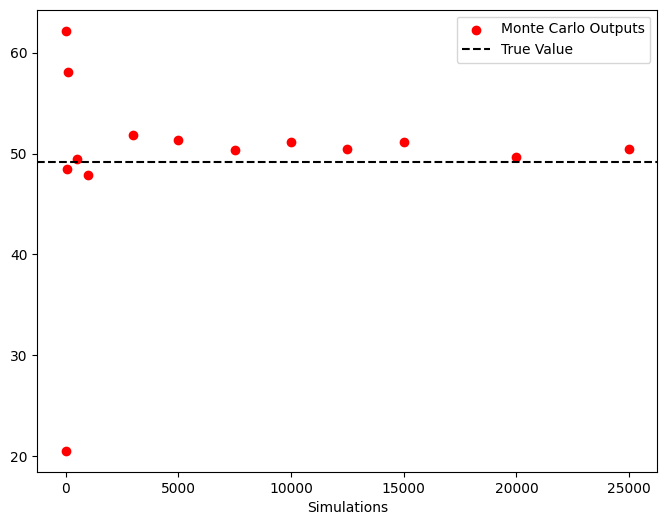

In [16]:
n_sims = [1,10,50,100,500,1000,3000,5000,7500,10000,12500,15000,20000,25000]
mc_results = [op.mc_call_price(n_sims=n) for n in n_sims]
plt.figure(figsize=(8,6))
plt.scatter(n_sims, mc_results, c="red", label="Monte Carlo Outputs")
plt.axhline(op.bs_call_price(), c="black", linestyle="--", label="True Value")
plt.legend()
plt.xlabel("Simulations")
plt.show()